In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime
import math
import QuantLib as ql
from scipy.optimize import minimize

from initialize import *
from plotting import *
from SABR import *
from Heston import *
from mixedSABR import *

,Tenors,Spot Rate
0,0.25,-0.575
1,1.00,-0.557
2,3.00,-0.549
3,6.00,-0.529
4,12.00,-0.494


Text(0.5, 1.0, 'EONIA Rates (%) 1996-2021')

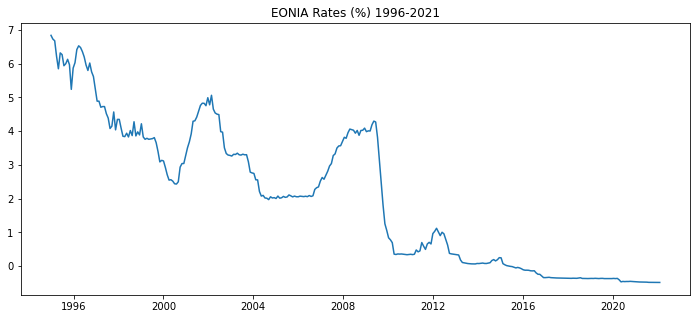

In [2]:
# Spot rates table and chart (EONIA)

rates = [-0.575, -0.557, -0.549, -0.529, -0.494]
tenors = [.25, 1, 3, 6, 12]

spot_rates = pd.DataFrame({"Tenors": tenors, "Spot Rate": rates})
spot_rates.set_index('Tenors')

display(spot_rates)

fig = plt.figure(figsize=(12,5))
eonia_dates = [datetime.date(1994, 12, 31) + datetime.timedelta(days=30*n) for n in range(len(eonia_rates['value']))]
plt.plot(eonia_dates, eonia_rates['value'])
plt.title("EONIA Rates (%) 1996-2021")

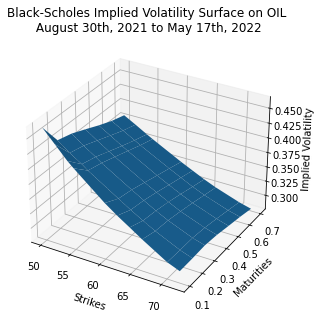

In [3]:
# BLACK VOLATILITY SURFACE

title = "Black-Scholes Implied Volatility Surface on {}\n {} to {}".format(data, today, dates[-1])
plot_vol_surface(vol_surface=black_var_surface, plot_strikes=strikes, funct='blackVol', title=title)

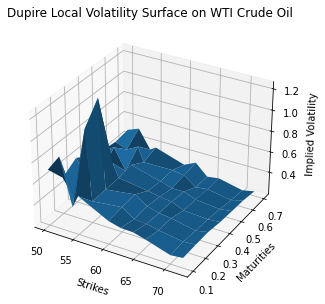

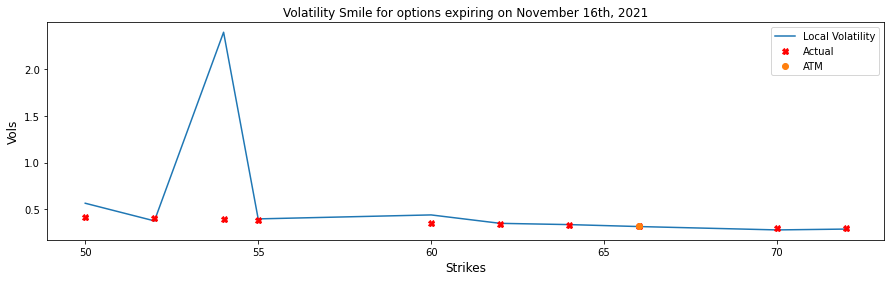

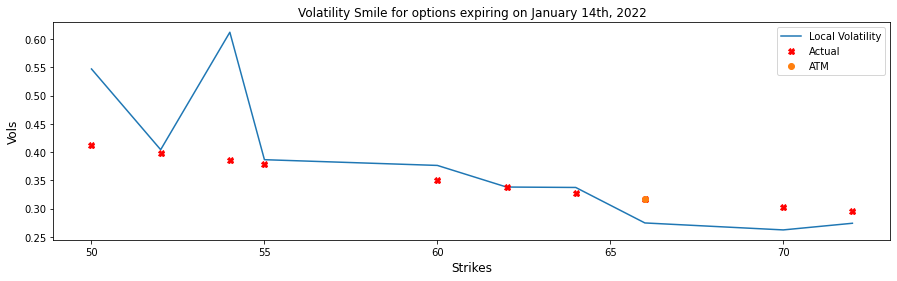

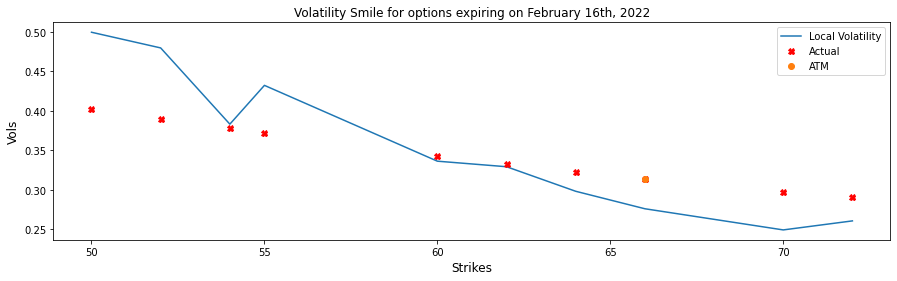

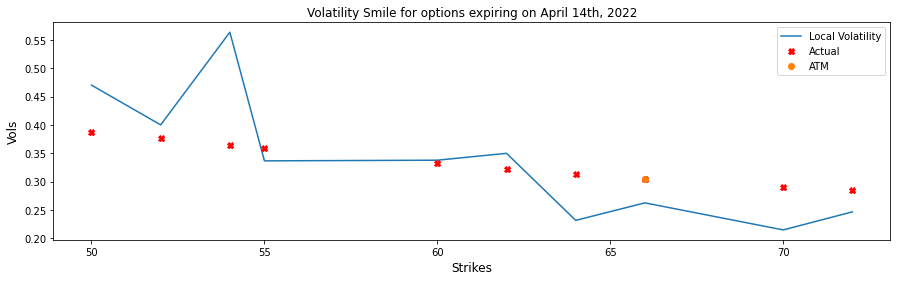

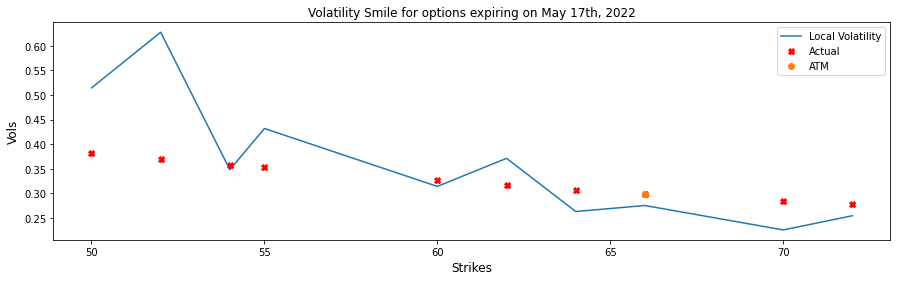

In [4]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

black_var_surface.setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)

# local_vol_surface = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)
local_vol_surface = ql.NoExceptLocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote, .1)

# Plot the Dupire surface ...
local_vol_surface.enableExtrapolation()
plot_vol_surface(local_vol_surface, funct='localVol', title="Dupire Local Volatility Surface on {}".format(data_label))

smiles_comparison(local_models=[local_vol_surface], black_volatility=False)

In [5]:
#HESTON MODEL SURFACE PLOTTING (Levenberg-Marquardt Method)

m1_params, m2_params = (None, None)
if data == "COFFEE":
    m1_params = (0.01,0.1,0.3,0.1,0.02)
    m2_params = (0.2,0.9,0.9,0.9,-0.19)
elif data == "OIL":
    m2_params = (0.023,0.009,1.00,0.95,0.2)
    m1_params = (0.15,0.5,0.2,0.7,0.01)
elif data == "GOLD":
    m1_params = (0.03,0.3,0.5,0.3,0.04)
    m2_params = (0.01,0.5,0.5,0.1,0.03)

hestonModel1 = hestonModelSurface(m1_params, label="Heston Model 1, {}".format(data_label))
hestonModel2 = hestonModelSurface(m2_params, label="Heston Model 2, {}".format(data_label))

# Use to Calibrate first time the Heston Model
def calibrateHeston():
    def f(params):
        return hestonModelSurface(params).avgError
        # v0, kappa, theta, sigma, rho
    cons = (
            {'type': 'ineq', 'fun': lambda x: x[0] - 0.001},
            {'type': 'ineq', 'fun': lambda x: 2. - x[0]},
            {'type': 'ineq', 'fun': lambda x: x[1] - 0.001},
            {'type': 'ineq', 'fun': lambda x: 2. - x[1]},
            {'type': 'ineq', 'fun': lambda x: x[2] - 0.001},
            {'type': 'ineq', 'fun': lambda x: 2. - x[2]},
            {'type': 'ineq', 'fun': lambda x: x[3] - 0.001},
            {'type': 'ineq', 'fun': lambda x: .999 - x[3]},
            {'type': 'ineq', 'fun': lambda x: .99 - x[4]**2}
            ) 
    result = minimize(f, m1_params, constraints=cons, method="SLSQP", bounds=((1e-8, None), (1e-8, None), (1e-8, None), (-.999, .999), (-.999, .999)))
    hestonModel0 = hestonModelSurface(result["x"], label="Heston Model 0, {}".format(data_label))


    plot_vol_surface(hestonModel0.heston_vol_surface, title="{} Volatility Surface".format(hestonModel0.label))
    plot_vol_surface(hestonModel1.heston_vol_surface, title="{} Volatility Surface".format(hestonModel1.label))

init_conditions = pd.DataFrame({"theta": [m1_params[0], m2_params[0]], "kappa": [m1_params[1], m2_params[1]], 
                                "sigma": [m1_params[2], m2_params[2]], "rho": [m1_params[3], m2_params[3]], 
                                "v0": [m1_params[4], m2_params[4]]}, index = ["Model1","Model2"])
display(init_conditions.style.set_caption("Heston Model Initial Conditions on ({})".format(data_label)))

,theta,kappa,sigma,rho,v0
Model1,0.150000,0.500000,0.200000,0.700000,0.010000
Model2,0.023000,0.009000,1.000000,0.950000,0.200000


,Strikes,Market Value,Model Value,Relative Error (%)
0,50.000000,1.745112,1.746440,0.076133
1,52.000000,2.065527,2.061412,-0.199202
2,54.000000,2.420076,2.422191,0.087392
3,55.000000,2.619973,2.621615,0.062658
4,60.000000,3.843719,3.844408,0.017915
5,62.000000,4.462640,4.458194,-0.099626
6,64.000000,5.155103,5.157405,0.044640
7,66.000000,5.951370,5.952312,0.015826
8,70.000000,5.469599,5.469317,-0.005154
9,72.000000,4.596370,4.596407,0.000804


,Value
v0,0.308045
kappa,0.597565
theta,1.011603
sigma,-0.476059
rho,0.076782
avgError,0.060935


No handles with labels found to put in legend.


,Strikes,Market Value,Model Value,Relative Error (%)
0,50.000000,1.745112,1.746490,0.078965
1,52.000000,2.065527,2.061364,-0.201541
2,54.000000,2.420076,2.422136,0.085120
3,55.000000,2.619973,2.621584,0.061479
4,60.000000,3.843719,3.844558,0.021805
5,62.000000,4.462640,4.458322,-0.096761
6,64.000000,5.155103,5.157405,0.044650
7,66.000000,5.951370,5.952109,0.012417
8,70.000000,5.469599,5.468998,-0.010995
9,72.000000,4.596370,4.596575,0.004449


,Value
v0,5.105062
kappa,0.045528
theta,1.015561
sigma,-0.483565
rho,0.038955
avgError,0.061818


No handles with labels found to put in legend.


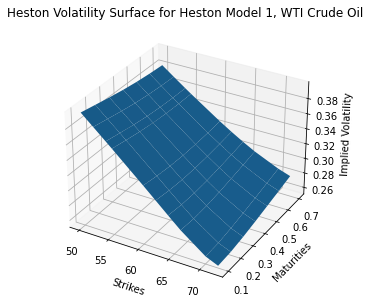

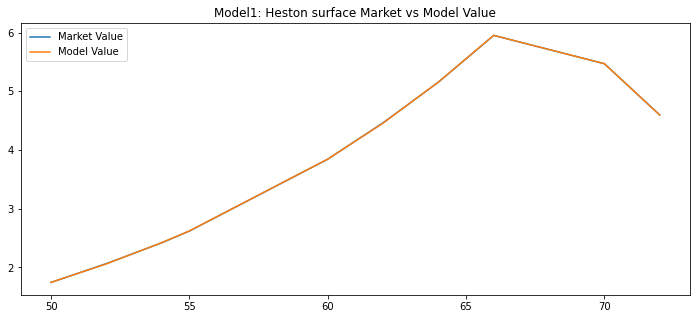

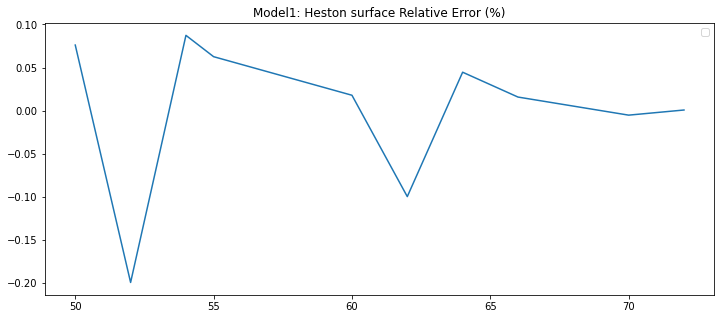

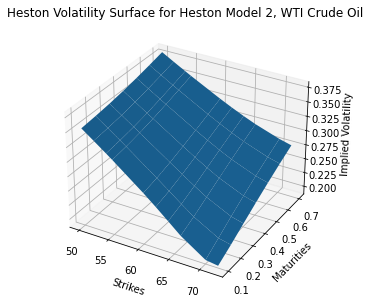

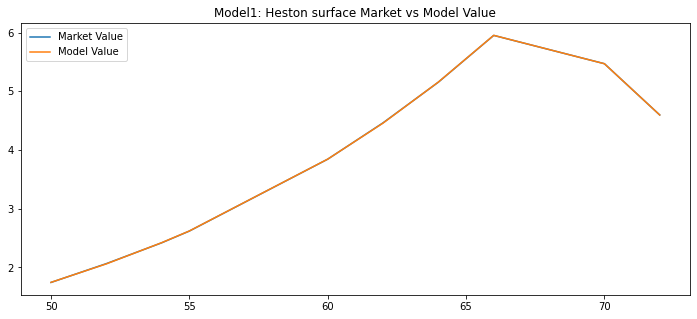

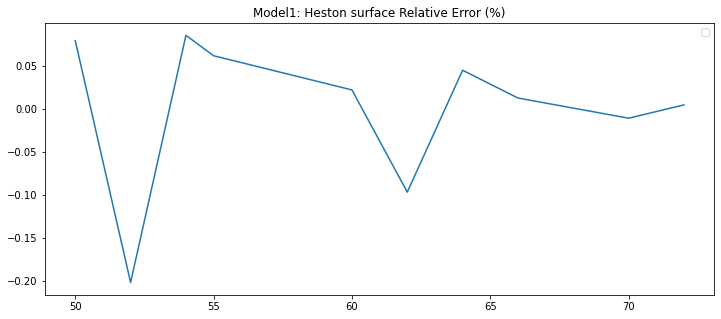

In [6]:
# HESTON Surface Plotting (Model1, Model2)

for model in (hestonModel1, hestonModel2):
    plot_vol_surface(model.heston_vol_surface, title="Heston Volatility Surface for {}".format(model.label))
    display(model.errors_data.style.set_caption("{} calibration results".format(model.label))); display(model.var_data.style.set_caption("{} parameters output".format(model.label)))

    fig1 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.marketValue, label="Market Value")
    plt.plot(model.strks, model.modelValue, label="Model Value")
    plt.title('Model1: Heston surface Market vs Model Value'); plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()
    fig2 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.relativeError)
    plt.title('Model1: Heston surface Relative Error (%)'); plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()

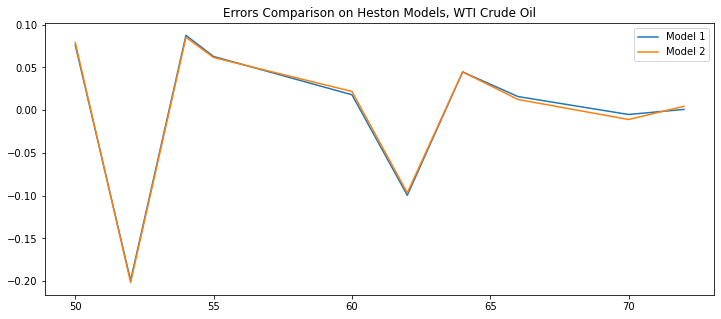

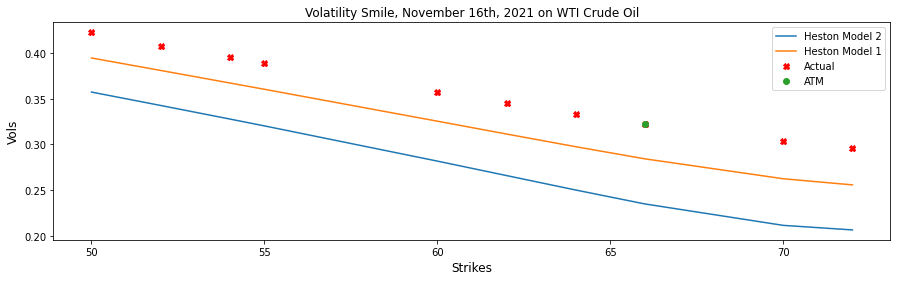

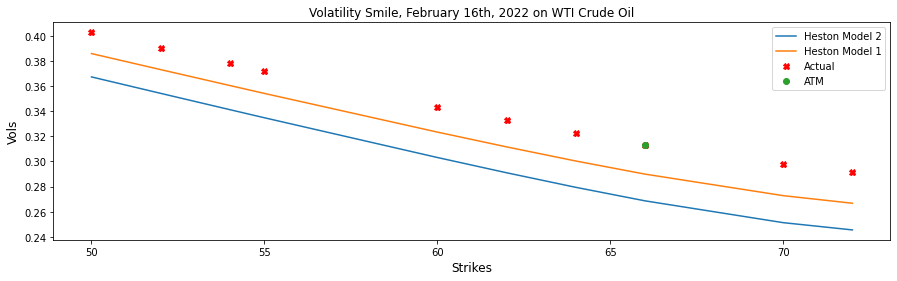

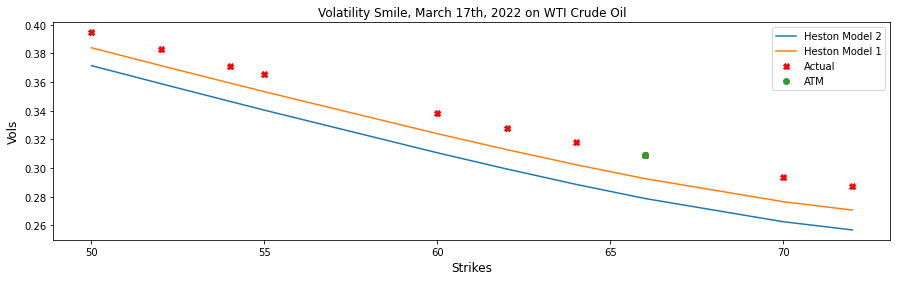

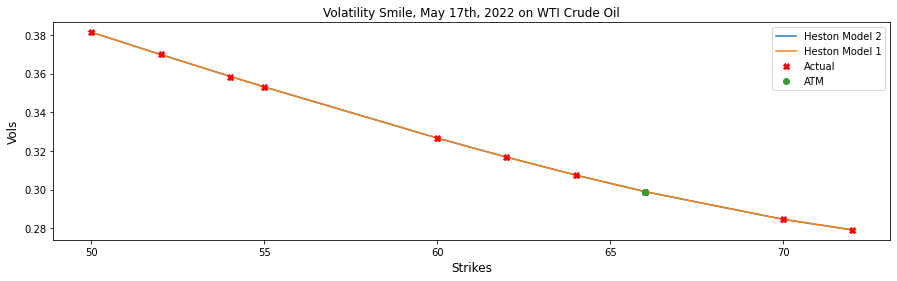

In [7]:
# Relative error comparison
plt.figure(figsize=plot_size)
plt.plot(hestonModel1.strks, hestonModel1.relativeError, label="Model 1")
plt.plot(hestonModel2.strks, hestonModel2.relativeError, label="Model 2")
plt.title("Errors Comparison on Heston Models, {}".format(data_label));
plt.legend()

# Volatility smiles comparison
tenors = [dates[round((len(dates)-1) * x)] for x in (.2, .5, .75, 1)]
for tenor in tenors:
    l = [
        ([hestonModel2.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 2" ),
        ([hestonModel1.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 1" )
        ]
    plot_smile(tenor, l, market=True)

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime
import math
import QuantLib as ql
from scipy.optimize import minimize

from initialize import *
from plotting import *

# CALIBRATE SABR VOLATILITY SURFACE

volMatrix = ql.Matrix(len(strikes), len(dates))

for i in range(len(vols)):
    for j in range(len(vols[i])):
        volMatrix[j][i] = vols[i][j]

black_var_surface = ql.BlackVarianceSurface(
    today, calendar, dates, strikes, volMatrix, day_count)
black_var_surface.enableExtrapolation()


class SABRSmile:
    def __init__(self, date, marketVols, shift=0, beta=1, method="normal", strikes=strikes, fwd=current_price, zero_rho=False):
        self.date = date
        self.expiryTime = round((self.date - today)/365, 6)
        self.marketVols = marketVols
        self.shift = shift
        self.strikes=strikes;
        self.fwd = fwd
        self.forward_price = self.fwd * \
            math.exp(rate.value() * self.expiryTime)
        self.zero_rho = zero_rho
        self.alpha, self.beta, self.nu, self.rho = (
            .1, beta, 0., 0. if self.zero_rho else .1)
        self.method = method
        self.newVols = None
        self.error = None

    def initialize(self):
        # alpha, beta, nu, rho
        cons = (
            {'type': 'ineq', 'fun': lambda x: x[0] - 0.001},
            {'type': 'eq', 'fun': lambda x: x[1] - self.beta},
            {'type': 'ineq', 'fun': lambda x: x[2] - .001},
            {'type': 'ineq', 'fun': lambda x: .99 - x[3]**2},
        )

        x = self.set_init_conds()

        result = minimize(self.f, x, constraints=cons, method="SLSQP", bounds=(
            (1e-8, None), (0, 1), (1e-8, None), (-.999, .999)))
        self.error = result['fun']
        [self.alpha, self.beta, self.nu, self.rho] = result['x']

        self.newVols = [self.vols_by_method(
            strike, self.alpha, self.beta, self.nu, self.rho) for strike in self.strikes]

    def set_init_conds(self):
        return [self.alpha, self.beta, self.nu, self.rho]

    def vols_by_method(self, strike, alpha, beta, nu, rho):
        if self.method == "floch-kennedy":
            return ql.sabrFlochKennedyVolatility(strike, self.forward_price, self.expiryTime, alpha, beta, nu, rho)
        elif self.shift != 0:
            return ql.shiftedSabrVolatility(strike, self.forward_price, self.expiryTime, alpha, beta, nu, rho, self.shift)
        else:
            return ql.sabrVolatility(strike, self.forward_price, self.expiryTime, alpha, beta, nu, rho)

    def f(self, params):

        alpha, beta, nu, rho = params

        vols = np.array([self.vols_by_method(
            strike, alpha, beta, nu, rho) for strike in self.strikes])

        self.error = ((vols - np.array(self.marketVols))**2).mean() ** .5

        return self.error


class SABRVolatilitySurface:
    def __init__(self, strks=strikes, method="normal", beta=1, shift=0, fwd=current_price, label="", zero_rho=False):
        self.method = method
        self._beta = beta
        self.shift = shift
        self.strikes = strks
        self.fwd = fwd
        self.label = label
        self.zero_rho = zero_rho

        self.initialize()

    def initialize(self):
        self.vol_surface_vector, self.errors, self.smiles, self.alpha, self.beta, self.nu, self.rho = [
        ], [], [], [], [], [], []
        self.SABRVolMatrix, self.SABRVolDiffMatrix = (
            ql.Matrix(len(self.strikes), len(dates)), ql.Matrix(len(self.strikes), len(dates)))

        for i, d in enumerate(dates):

            v = []
            for j in range(len(self.strikes)):
                if self.strikes[i] in strikes:
                    v.append(vols[i][j])
                        
            volSABR = SABRSmile(date=d, beta=self._beta, strikes=self.strikes, marketVols=v, shift=self.shift,
                                method=self.method, fwd=self.fwd, zero_rho=self.zero_rho)
            volSABR.initialize()
            
            self.alpha.append(volSABR.alpha)
            self.beta.append(volSABR.beta)
            self.nu.append(volSABR.nu)
            self.rho.append(volSABR.rho)

            self.errors.append(volSABR.error)

            smile = volSABR.newVols

            self.vol_surface_vector.extend(smile)
            self.smiles.append(volSABR)

            # constructing the SABRVolatilityMatrix
            for j in range(len(smile)):
                self.SABRVolMatrix[j][i] = smile[j]
                self.SABRVolDiffMatrix[j][i] = (
                    smile[j] - v[j]) / v[j]

            self.vol_surface = ql.BlackVarianceSurface(
                today, calendar, dates, self.strikes, self.SABRVolMatrix, day_count)
            self.vol_surface.enableExtrapolation()

    def to_data(self):
        d = {'alpha': self.alpha, 'beta': self.beta,
             'nu': self.nu, 'rho': self.rho}
        return pd.DataFrame(data=d, index=dates)


# Backbone modelling for SABR
def SABR_backbone_plot(beta=1, bounds=None, shift=0, strikes=strikes, fixes=(.95, 1, 1.14, 1.24), tenor=dates[2]):
    l = []
    for i in fixes:
        vol_surface = SABRVolatilitySurface(
            method="normal", shift=current_price*shift, beta=beta, fwd=current_price * i)
        SABR_vol_surface = ql.BlackVarianceSurface(
            today, calendar, dates, strikes, vol_surface.SABRVolMatrix, day_count)
        SABR_vol_surface.enableExtrapolation()

        l.append(([SABR_vol_surface.blackVol(tenor, s)
                 for s in strikes], "fwd = {}".format(current_price * i)))

    plot_smile(tenor, l, bounds=bounds, market=False,
               title="backbone, beta = {}, {}".format(vol_surface.beta[0], tenor))


def SABRComparison(methods, title="", display=False):
    fig, axs = plt.subplots(2, 2, figsize=plot_size)
    plt.subplots_adjust(left=None, bottom=None, right=None,
                        top=1.5, wspace=None, hspace=None)

    for method in methods:
        lbl = "beta={}".format(method.beta[1])
        axs[0, 0].plot(maturities, method.alpha, label=lbl)
        axs[0, 0].set_title('{}: Alpha'.format(title))
        axs[0, 0].set(xlabel='maturities', ylabel='value')
        axs[0, 0].legend()
        axs[1, 0].plot(maturities, method.nu, label=lbl)
        axs[1, 0].set_title('{}: Nu'.format(title))
        axs[1, 0].set(xlabel='maturities', ylabel='value')
        axs[1, 0].legend()
        axs[0, 1].plot(maturities, method.rho, label=lbl)
        axs[0, 1].set_title('{}: Rho'.format(title))
        axs[0, 1].set(xlabel='maturities', ylabel='value')
        axs[0, 1].legend()
        axs[1, 1].plot(maturities, method.errors, label=lbl)
        axs[1, 1].set_title('{}: MSE'.format(title))
        axs[1, 1].set(xlabel='maturities', ylabel='value')
        axs[1, 1].legend()

        if display:
            method_df = method.to_data()
            display(method_df.style.set_caption("SABR, {}".format(lbl)))

        plot_vol_surface(method.vol_surface, title="{}".format(method.label))

    smiles_comparison(methods)


In [9]:
strikes

array([50., 52., 54., 55., 60., 62., 64., 66., 70., 72.])

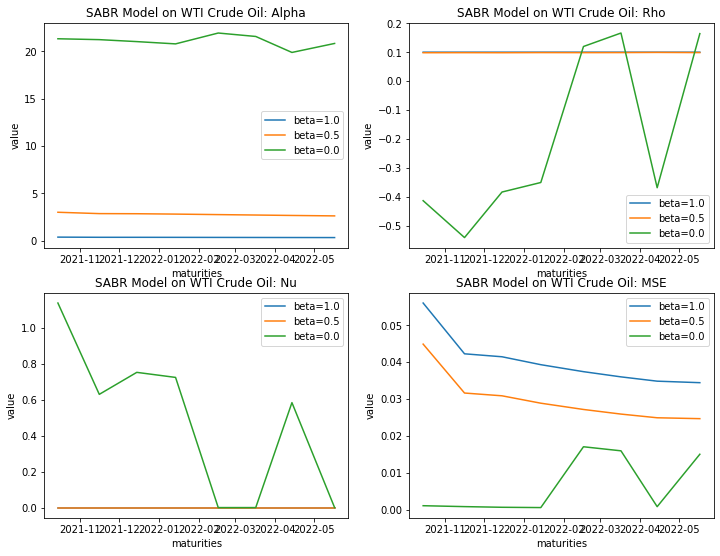

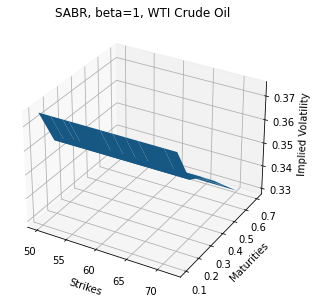

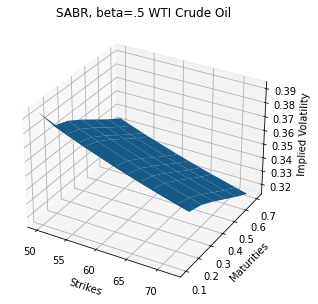

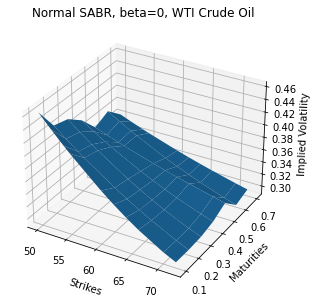

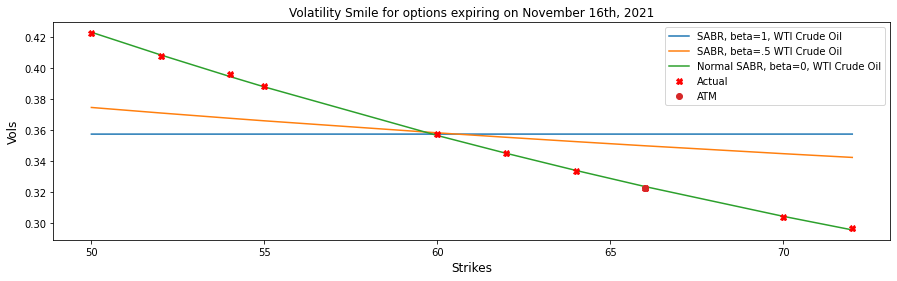

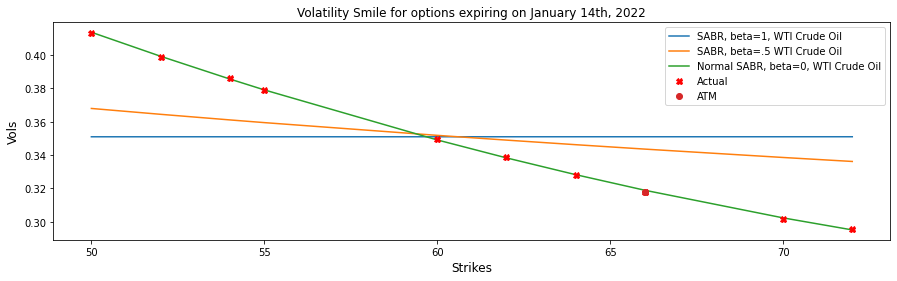

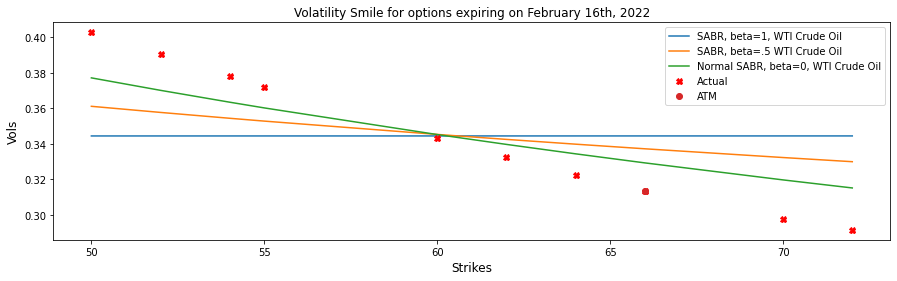

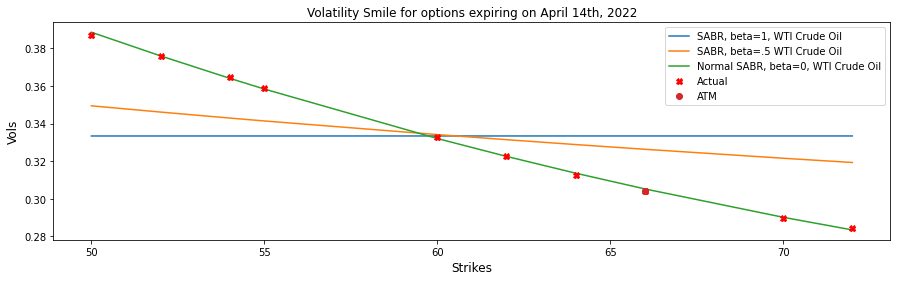

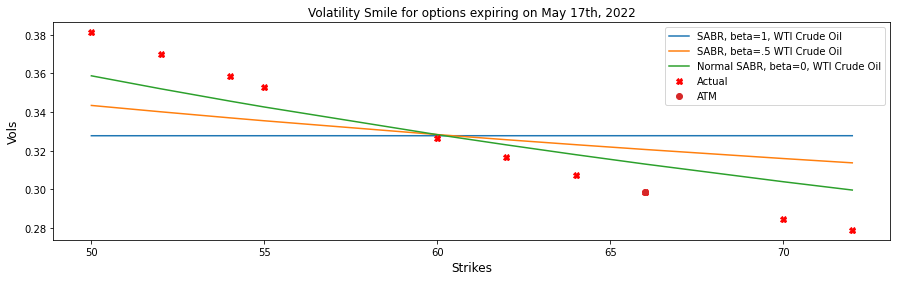

In [10]:
# SABR Volatility model
strks = strikes
SABR_beta1 = SABRVolatilitySurface(beta=1, shift=0, strks=strks, label="SABR, beta=1, {}".format(data_label))
SABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, strks=strks, label="SABR, beta=.5 {}".format(data_label))
SABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, strks=strks, label="Normal SABR, beta=0, {}".format(data_label))
        
SABRComparison([SABR_beta1, SABR_beta5, SABR_beta0], title="SABR Model on {}".format(data_label))

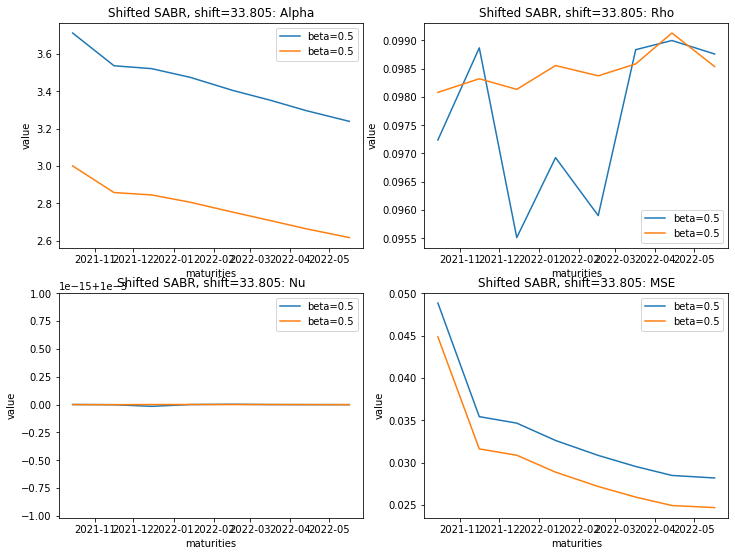

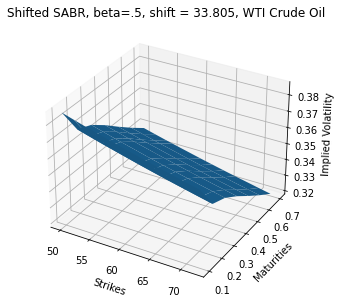

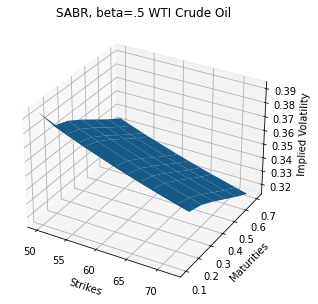

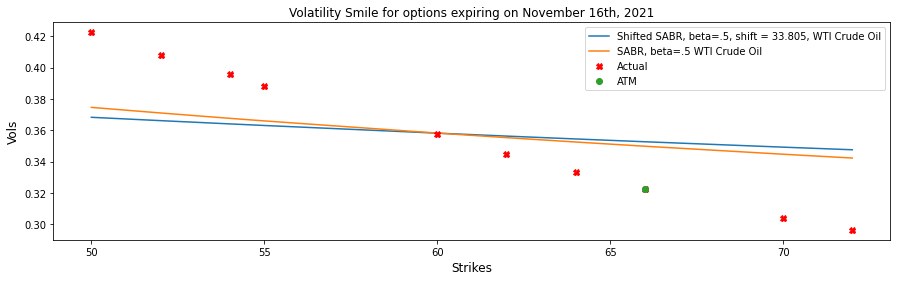

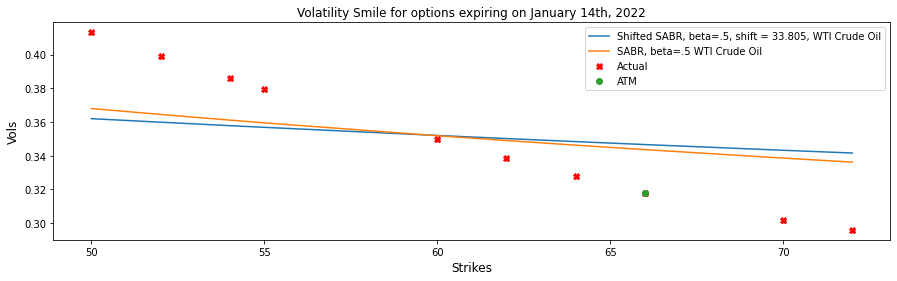

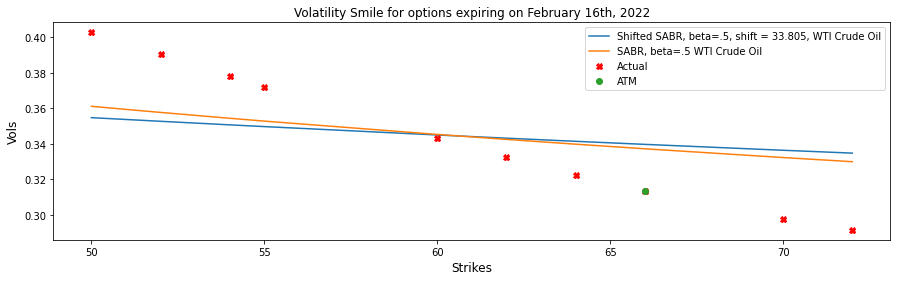

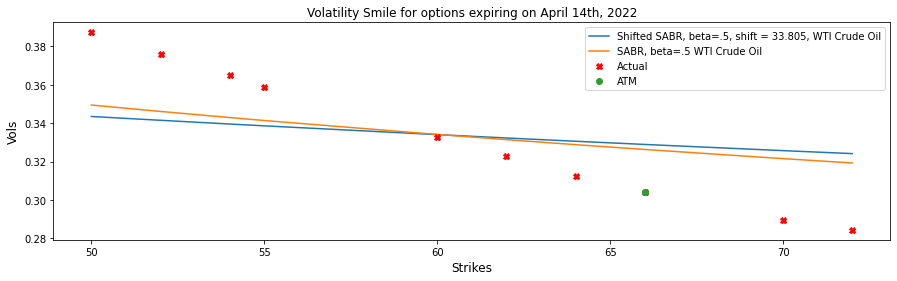

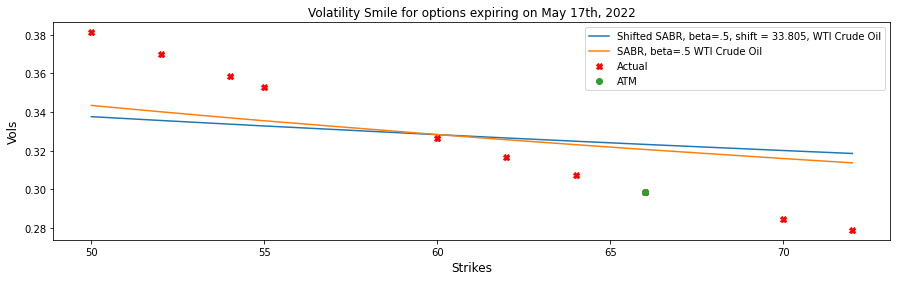

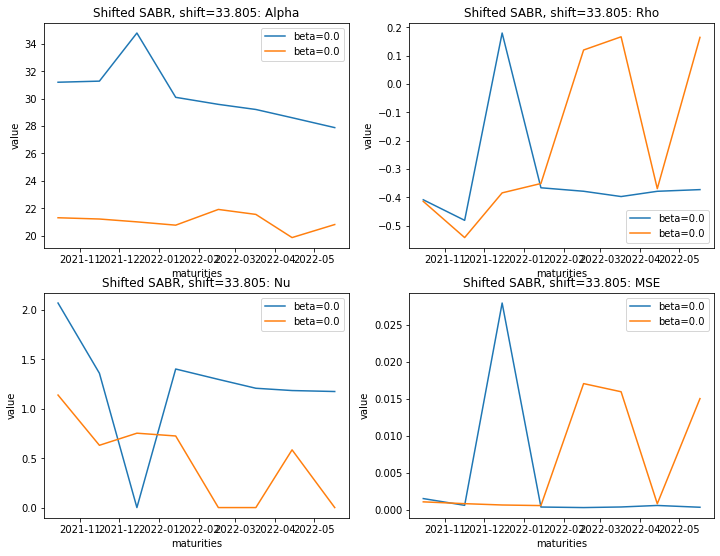

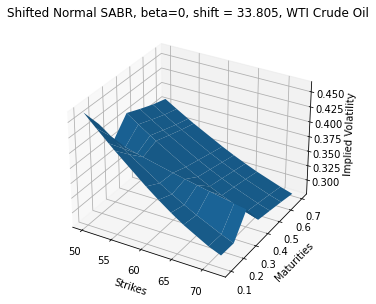

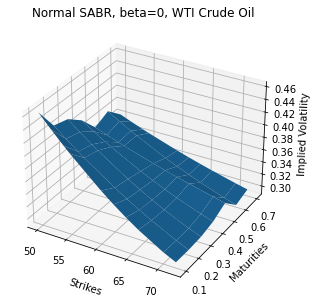

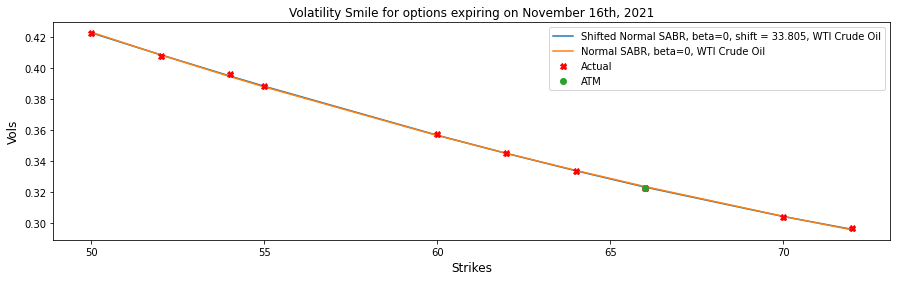

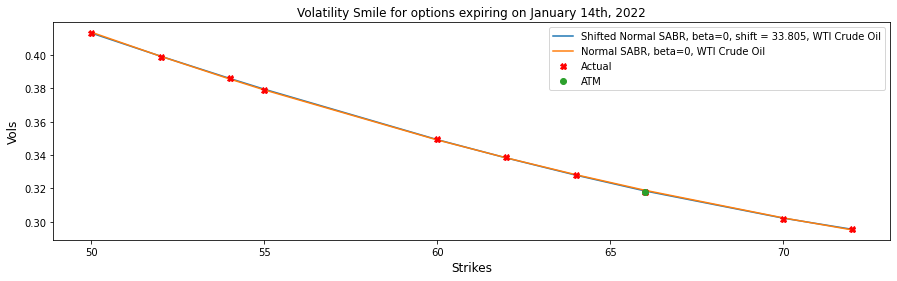

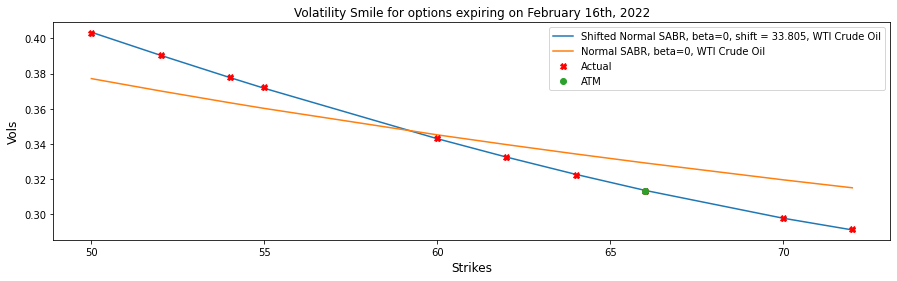

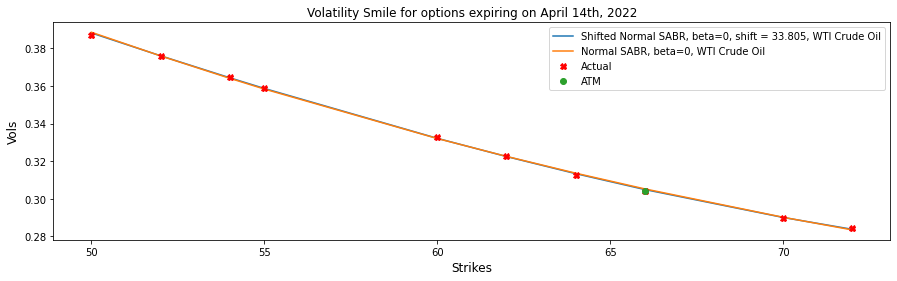

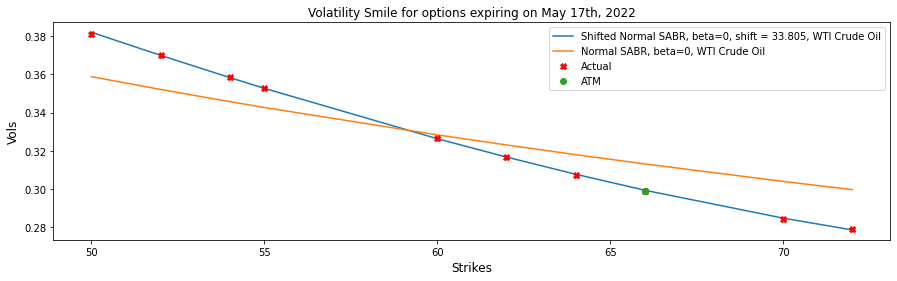

In [11]:
# Shifted SABR Volatility model
shft = .50 * current_price
shiftedSABR_beta1 = SABRVolatilitySurface(beta=1, shift=shft,strks=strikes, label="Shifted SABR, beta=1, shift = {}, {}".format(round(shft, 4), data_label))
shiftedSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=shft, strks=strikes,label="Shifted SABR, beta=.5, shift = {}, {}".format(round(shft, 4), data_label))
shiftedSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=shft, strks=strikes,label="Shifted Normal SABR, beta=0, shift = {}, {}".format(round(shft, 4), data_label))

SABRComparison([shiftedSABR_beta5, SABR_beta5], title="Shifted SABR, shift={}".format(round(shft, 4)))
SABRComparison([shiftedSABR_beta0, SABR_beta0], title="Shifted SABR, shift={}".format(round(shft, 4)))

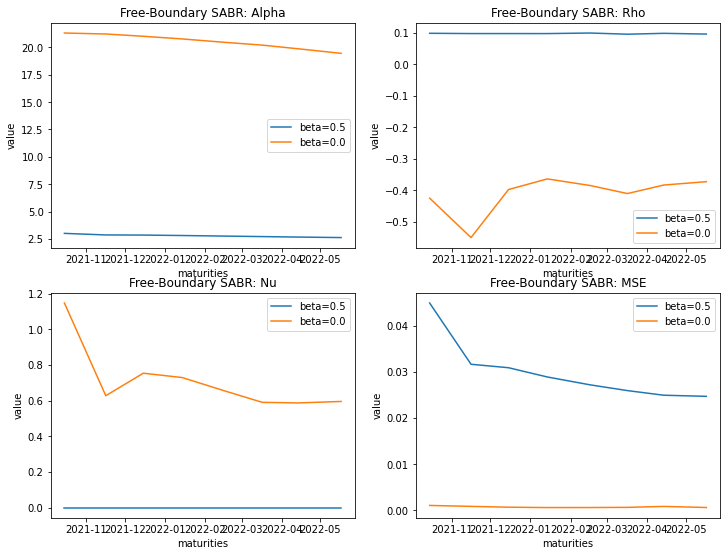

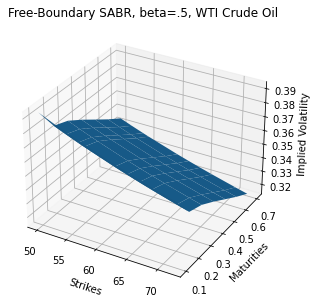

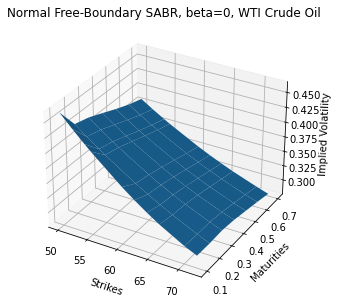

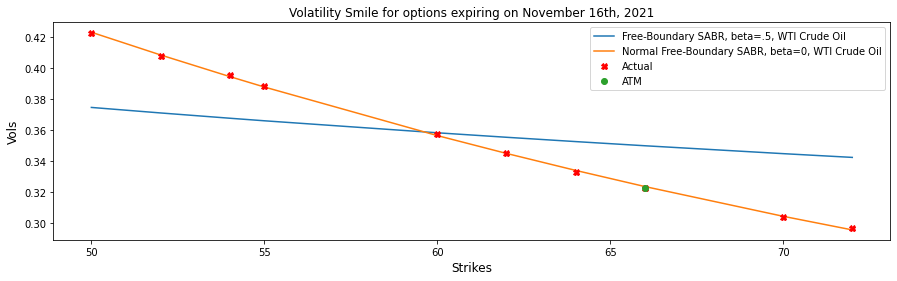

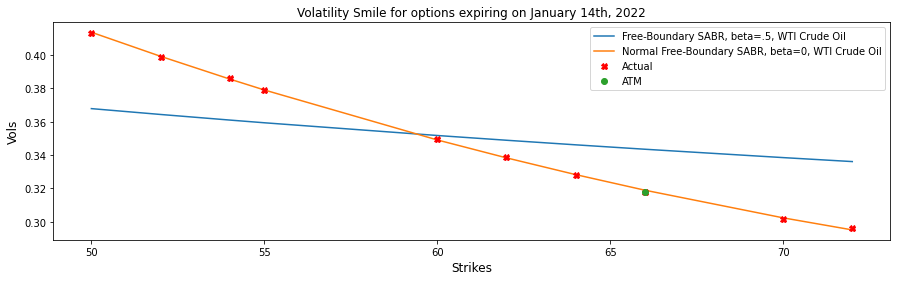

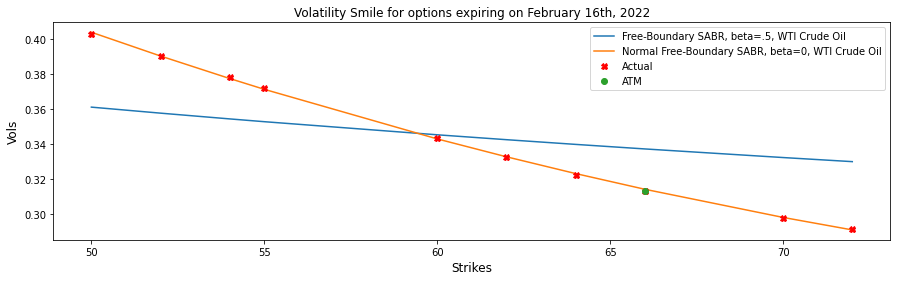

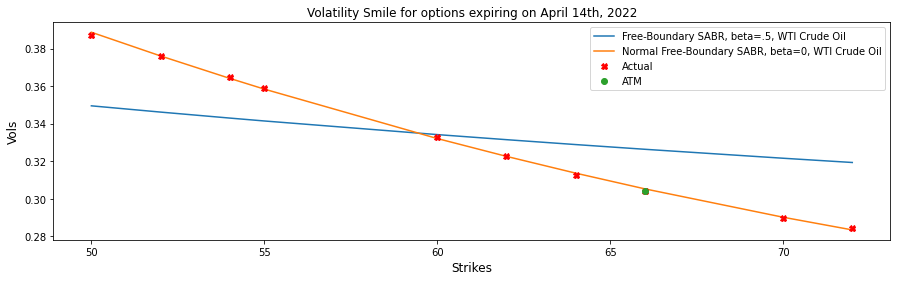

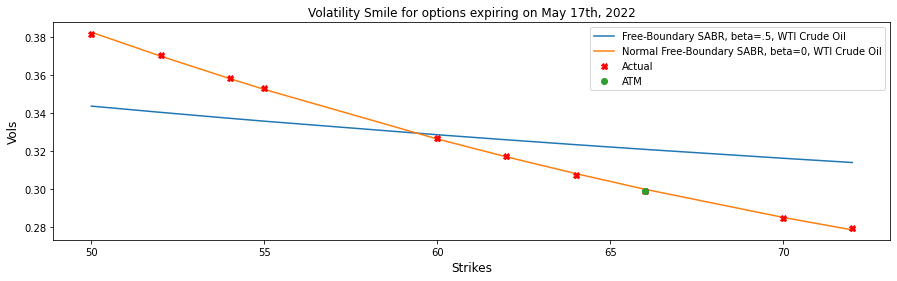

In [12]:
# Free-Boundary SABR Volatility model

freeSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, method="floch-kennedy", strks=strikes, label="Free-Boundary SABR, beta=.5, {}".format(data_label))
freeSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, method="floch-kennedy", strks=strikes, label="Normal Free-Boundary SABR, beta=0, {}".format(data_label))

SABRComparison([freeSABR_beta5, freeSABR_beta0], title="Free-Boundary SABR")

C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


,alpha_free,beta_free,nu_free,rho_free,alpha_N,beta_N,nu_N,rho_N,MSE
"October 15th, 2021",2.594452,0.5,1.356339,0.0,2.594452,0.0,2.712679,0.746176,0.026077
"November 16th, 2021",2.588917,0.5,0.858386,0.0,2.588917,0.0,1.716772,0.990000,0.030752
"December 15th, 2021",2.563302,0.5,0.958438,0.0,2.563302,0.0,1.916877,0.980988,0.025228
"January 14th, 2022",2.535015,0.5,0.926916,0.0,2.535015,0.0,1.853832,0.990000,0.025516
"February 16th, 2022",2.499337,0.5,0.858357,0.0,2.499337,0.0,1.716713,0.990000,0.029981
"March 17th, 2022",2.470763,0.5,0.799717,0.0,2.470763,0.0,1.599434,0.990000,0.036393
"April 14th, 2022",2.430085,0.5,0.790166,0.0,2.430085,0.0,1.580332,0.990000,0.037640
"May 17th, 2022",2.380961,0.5,0.793399,0.0,2.380961,0.0,1.586797,0.990000,0.037261


No handles with labels found to put in legend.


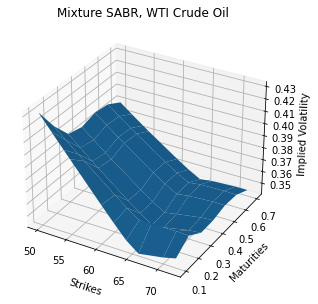

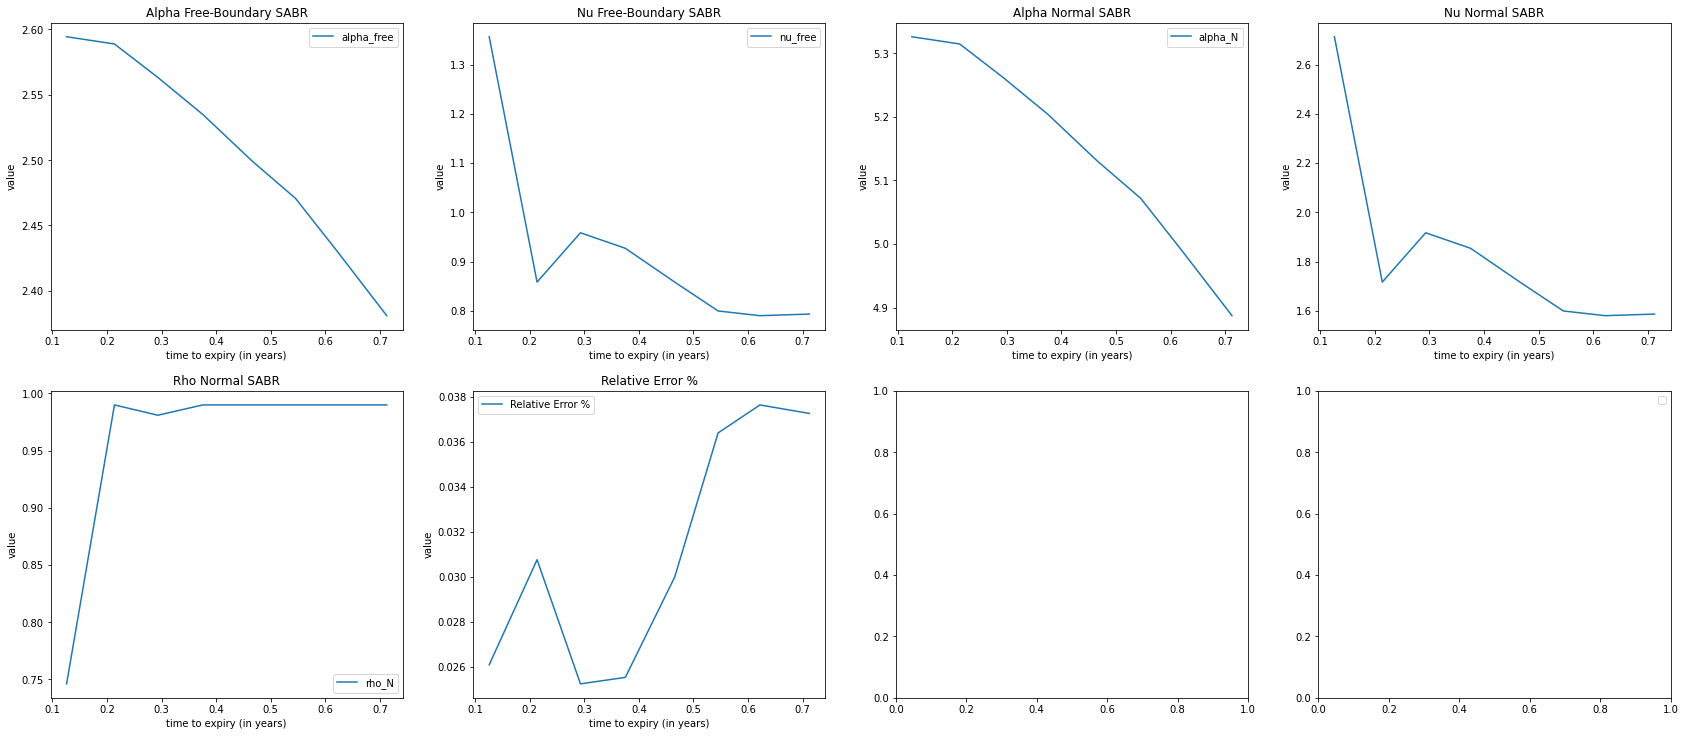

In [13]:
# Mixed SABR 

mixtureSABR = MixtureSABRVolatilitySurface(dates=dates) 
display(mixtureSABR.to_data())
plot_vol_surface([mixtureSABR.vol_surface], title=mixtureSABR.label)
mixtureSABR.plot()

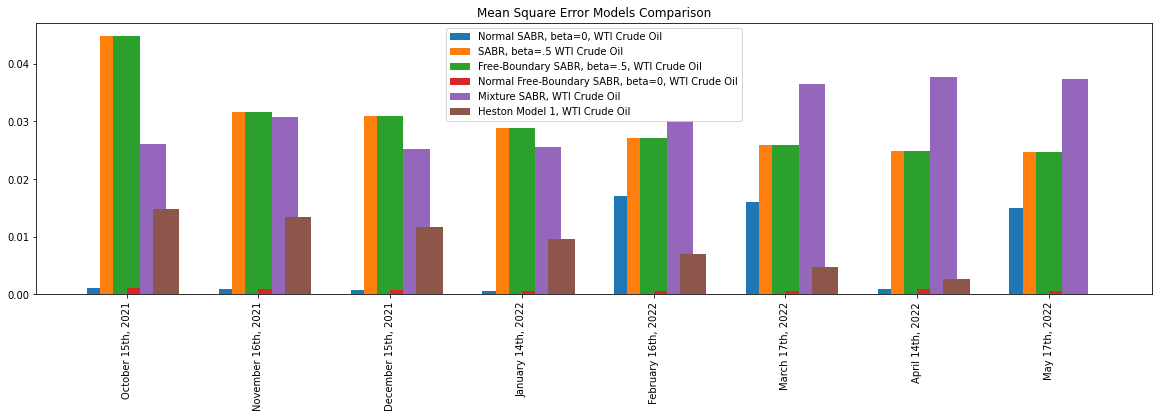

In [14]:
# VOLATILITY SMILES ERRORS COMPARISON

fig = plt.figure(figsize=(20, 5), )
width = .20
plt.bar(np.arange(len(maturities)) - 2*width/2, SABR_beta0.errors, label=SABR_beta0.label, width=width)
plt.bar(np.arange(len(maturities)) - width/2, SABR_beta5.errors, label=SABR_beta5.label, width=width)
plt.bar(np.arange(len(maturities)) , freeSABR_beta5.errors, label=freeSABR_beta5.label, width=width)
plt.bar(np.arange(len(maturities)) + width/2, freeSABR_beta0.errors, label=freeSABR_beta0.label, width=width)
plt.bar(np.arange(len(maturities)) + 2*width/2, mixtureSABR.errors, label=mixtureSABR.label, width=width)
plt.bar(np.arange(len(maturities)) + 3*width/2, hestonModel1.errors, label=hestonModel1.label, width=width)
plt.xticks(np.arange(len(maturities)), dates, rotation='vertical')
plt.title("Mean Square Error Models Comparison")
plt.legend()

,Error
"Normal SABR, beta=0, WTI Crude Oil",0.006528
"SABR, beta=.5 WTI Crude Oil",0.029863
"Normal Free-Boundary SABR, beta=0, WTI Crude Oil",0.000762
"Free-Boundary SABR, beta=.5, WTI Crude Oil",0.029863
"Mixture SABR, WTI Crude Oil",0.031106


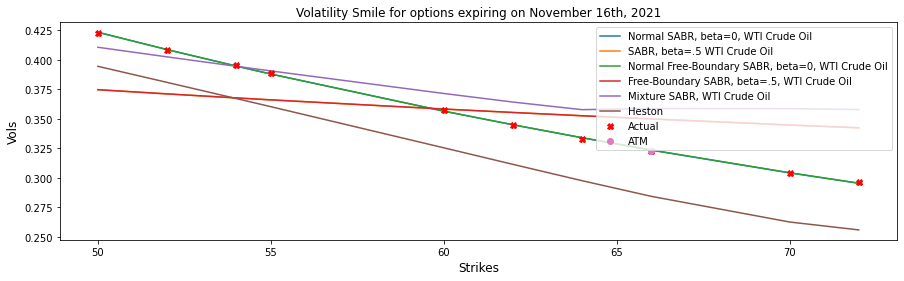

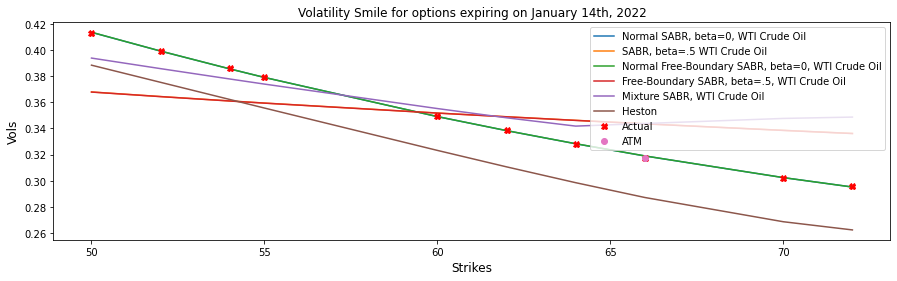

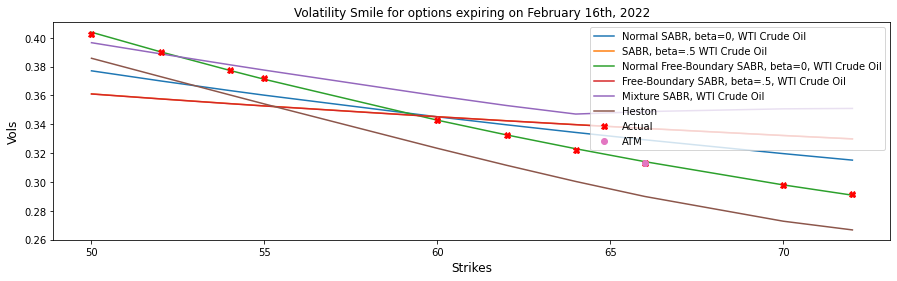

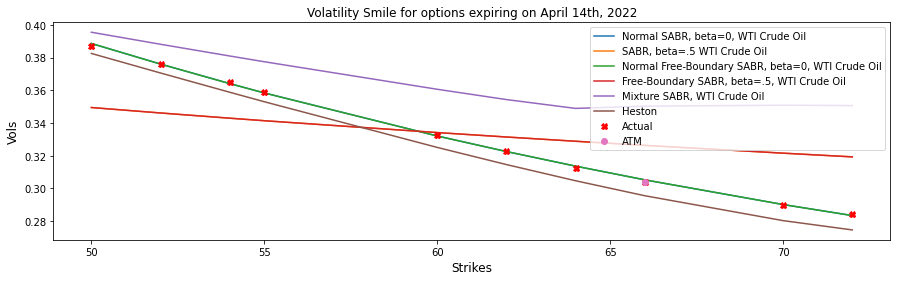

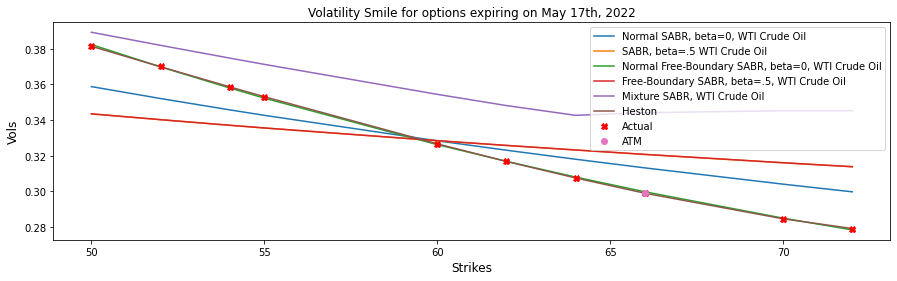

In [15]:
# Volatility Smiles Comparisons (Final)

models = (
        SABR_beta0,
        SABR_beta5, 
        freeSABR_beta0, 
        freeSABR_beta5,
        mixtureSABR
        )

errors_data = pd.DataFrame([np.mean(m.errors) for m in models], index=[m.label for m in models], columns=["Error"])
display(errors_data)

smiles_comparison(models, heston_models=[hestonModel1])

,Error
"SABR, beta=1, WTI Crude Oil",0.040201
"SABR, beta=.5 WTI Crude Oil",0.029863
"Shifted SABR, beta=1, shift = 33.805, WTI Crude Oil",0.040198
"Shifted SABR, beta=.5, shift = 33.805, WTI Crude Oil",0.033575
"Normal Free-Boundary SABR, beta=0, WTI Crude Oil",0.000762
"Free-Boundary SABR, beta=.5, WTI Crude Oil",0.029863


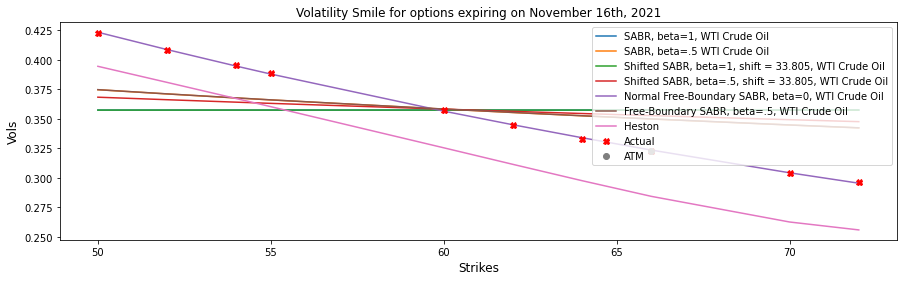

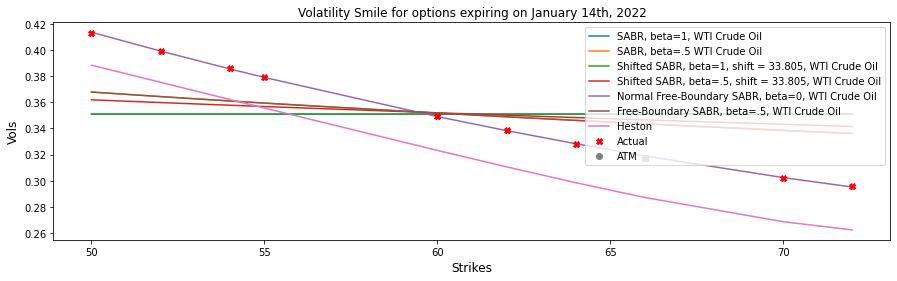

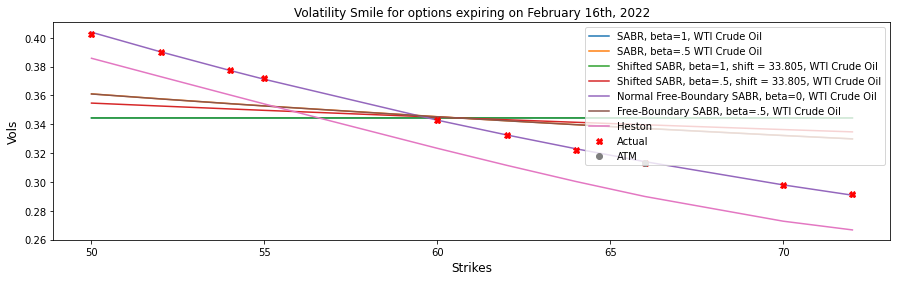

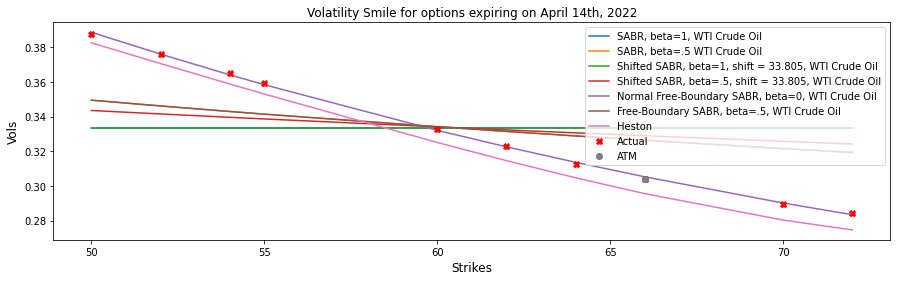

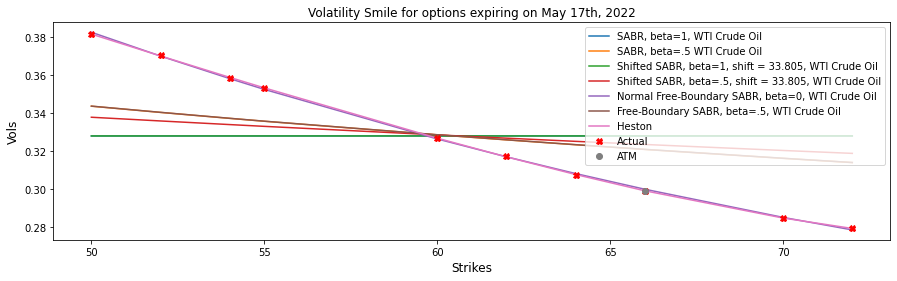

In [16]:
# Volatility Smiles Comparisons 2 (Final)

models = (
        SABR_beta1,
        SABR_beta5, 
        shiftedSABR_beta1,
        shiftedSABR_beta5,
        freeSABR_beta0, 
        freeSABR_beta5,
        )

errors_data = pd.DataFrame([np.mean(m.errors) for m in models], index=[m.label for m in models], columns=["Error"])
display(errors_data)

smiles_comparison(models, heston_models=[hestonModel1])

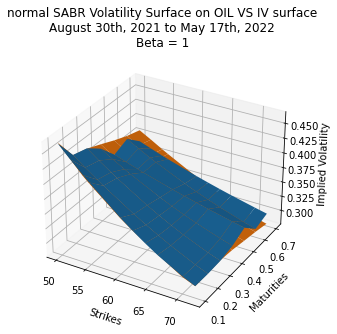

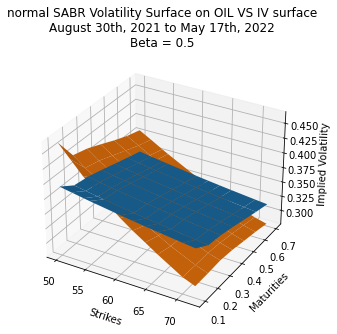

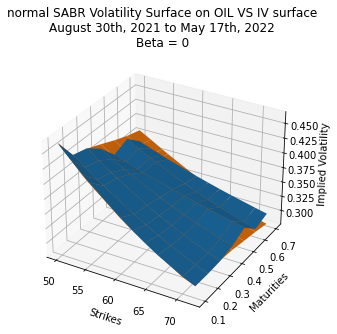

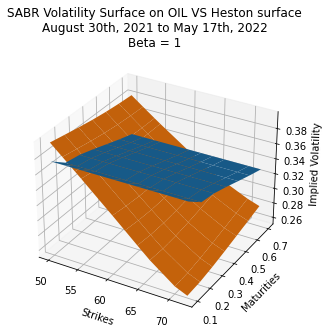

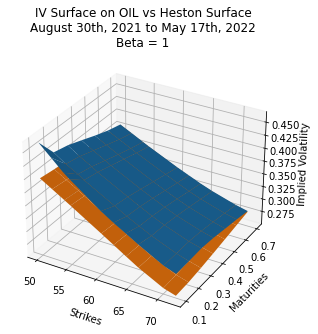

In [17]:
# Volatility Surfaces plots comparison

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0.5".format(data, today, dates[-1])
plot_vol_surface([SABR_beta5.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0".format(data, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "SABR Volatility Surface on {} VS Heston surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([SABR_beta1.vol_surface, hestonModel1.heston_vol_surface], title=title)

title = "IV Surface on {} vs Heston Surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([black_var_surface, hestonModel1.heston_vol_surface], title=title)

(None, None, None)

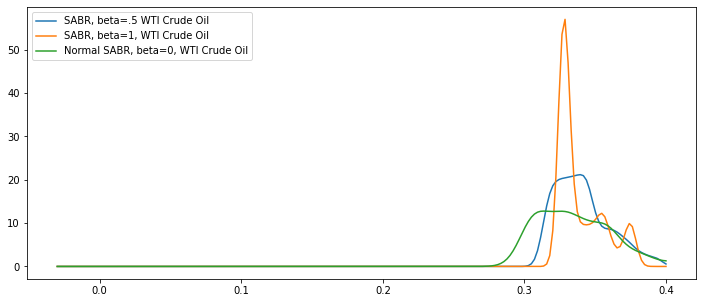

In [18]:
from scipy.stats import gaussian_kde
import seaborn as sns
plt.figure(figsize=plot_size)
def density(model):
    rn = []
    for i in np.arange(0, 1.5, .01):
        for j in np.arange(model.vol_surface.minStrike(), model.vol_surface.maxStrike(), 5):
            rn.append(model.vol_surface.blackVol(i,j))

    density = gaussian_kde(rn)
    xs = np.linspace(-.03,.4,200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs), label=model.label)
    
    plt.legend()



density(SABR_beta5), density(SABR_beta1), density(SABR_beta0), 

C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\somig\AppData\R

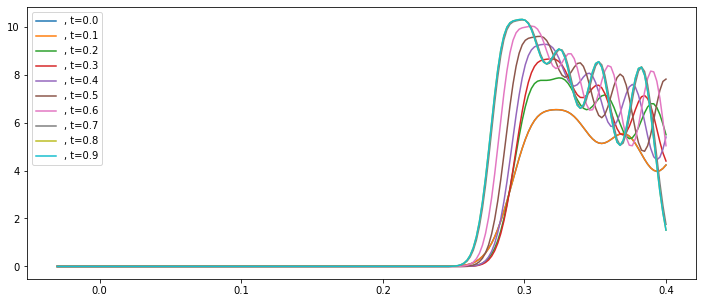

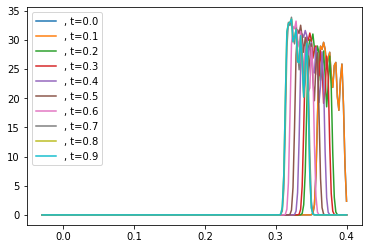

In [19]:
from scipy.stats import gaussian_kde

plt.figure(figsize=plot_size)
def density(model, t):
    rn = []

    for j in np.arange(model.vol_surface.minStrike(), model.vol_surface.maxStrike(), 5):
        rn.append(model.vol_surface.blackVol(t,j))

    density = gaussian_kde(rn)
    xs = np.linspace(-.03,.4,200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs), label=model.label+", t="+str(round(t, 2)))
    
    plt.legend()


for i in np.arange(0,1,.1):
    density(SABRVolatilitySurface(beta=.5, zero_rho=True), i)
plt.show()
for i in np.arange(0,1,.1):
    density(SABRVolatilitySurface(beta=.5, zero_rho=False), i)
